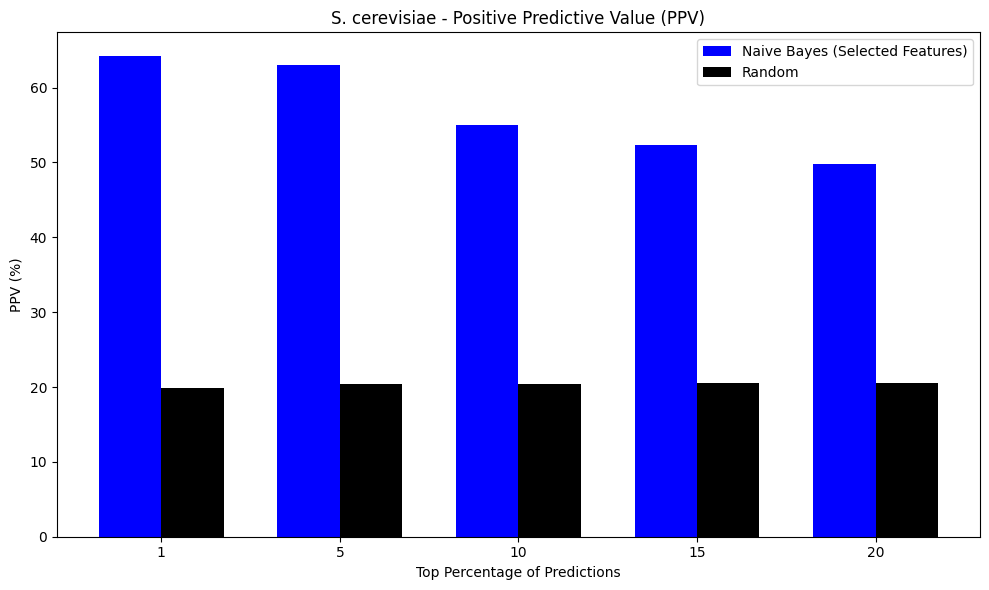

In [13]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Caricamento dei dati
df = pd.read_excel('cerevisiae_data.xls')

# Separazione delle classi
essential = df[df['Essential'] == 1]
non_essential = df[df['Essential'] == 0]

# Parametri
percentages = [1, 5, 10, 15, 20]
n_bootstrap = 100

# Funzione per calcolare il PPV
def calculate_ppv(y_true, y_prob, percentage):
    top_k = int(len(y_true) * (percentage / 100))
    top_indices = np.argsort(y_prob)[::-1][:top_k]
    return y_true.iloc[top_indices].mean() * 100

# Preprocessing e Feature Scaling
X = df.drop(columns=['Essential', 'orf_id'])
y = df['Essential']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Selezione delle caratteristiche
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)
top_features_idx = np.argsort(mi_scores)[-10:]  # Seleziona le migliori 10 caratteristiche
X_selected = X_scaled[:, top_features_idx]

# Dizionari per raccogliere i risultati
ppv_results = {p: [] for p in percentages}

# Bootstrap
for i in range(n_bootstrap):
    # Campionamento casuale bilanciato per il training set
    essential_train = essential.sample(frac=0.5, random_state=i)
    non_essential_train = non_essential.sample(frac=0.5, random_state=i)

    essential_test = essential.drop(essential_train.index)
    non_essential_test = non_essential.drop(non_essential_train.index)

    X_train = pd.concat([essential_train, non_essential_train]).drop(columns=['Essential', 'orf_id'])
    y_train = pd.concat([essential_train, non_essential_train])['Essential']

    X_test = pd.concat([essential_test, non_essential_test]).drop(columns=['Essential', 'orf_id'])
    y_test = pd.concat([essential_test, non_essential_test])['Essential']

    # Scaling
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Selezione delle stesse caratteristiche sul test set
    X_train_selected = X_train_scaled[:, top_features_idx]
    X_test_selected = X_test_scaled[:, top_features_idx]

    # Modello Naive Bayes
    model = GaussianNB()
    model.fit(X_train_selected, y_train)

    # Predizioni probabilistiche
    y_prob = model.predict_proba(X_test_selected)[:, 1]

    # Calcolo del PPV per ogni percentuale
    for p in percentages:
        ppv = calculate_ppv(y_test, y_prob, p)
        ppv_results[p].append(ppv)

# Calcolo della media dei PPV per ogni percentuale
top_ppv_means = {p: np.mean(ppv_results[p]) for p in percentages}

# Controllo casuale
random_ppv_results = []
for p in percentages:
    random_ppv = []
    for _ in range(n_bootstrap):
        top_k = int(len(y_test) * (p / 100))
        random_sample = y_test.sample(n=top_k, random_state=_)
        random_ppv.append(random_sample.mean() * 100)
    random_ppv_results.append(np.mean(random_ppv))

# Grafico
bar_width = 0.35
x = np.arange(len(percentages))

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width / 2, top_ppv_means.values(), width=bar_width, label='Naive Bayes (Selected Features)', color='blue')
plt.bar(x + bar_width / 2, random_ppv_results, width=bar_width, label='Random', color='black')

plt.xticks(x, percentages)
plt.xlabel('Top Percentage of Predictions')
plt.ylabel('PPV (%)')
plt.title('S. cerevisiae - Positive Predictive Value (PPV)')
plt.legend()
plt.tight_layout()
plt.show()
